<a href="https://colab.research.google.com/github/RozitaAbdoli/credit_default_mining/blob/main/FE_scaling%2Bbalancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook:
* Feature engineering: scale the input variables between zero and 1 before applying logistic regression
* balancing the dataset by under-sampling + LR
* balancing the dataset by uover-sampling + LR
* Balancing the datasey by a combination of under-sampling and over-sampling (SMOTE Tomek) + LR
* Will use sklearn's LogisticRegression which is a regularized regression with hyperparameter "penalty" for regularization to address overfitting. Default is l2 (Ridge). 
* Embedded method of feature selection: Will try the "zeroing" regularization method l1 (LASSO).


### Conclusions
* Balancing the dataset improved recall, but deteriorated accuracy and precision
* The method of resampling (undersampling, oversampling, SMOTETomek) performed equally

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn import preprocessing

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#Import Drive API and authenticate
from google.colab import drive
#Mount Drive to the Colab VM
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load the dataset into pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Capstone_project/v2_credit_default.csv")

In [ ]:
#Seperate the independent and dependent variables.
df_independent = df.drop(['Default'], axis=1)
df_default = df['Default']

In [ ]:
# split the data into 70% training and 30% test
x_train, x_test, y_train, y_test = train_test_split(df_independent, df_default, test_size=0.30, random_state=1) 

Make sure the distribution of the dependent variable is the same in both training and test sets.

0    16354
1     4621
Name: Default, dtype: int64

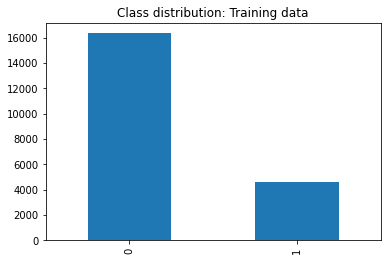

In [ ]:
# training data
y_train.value_counts().plot(kind='bar', title='Class distribution: Training data');
y_train.value_counts()    #22% defaulters in the training data

0    6981
1    2009
Name: Default, dtype: int64

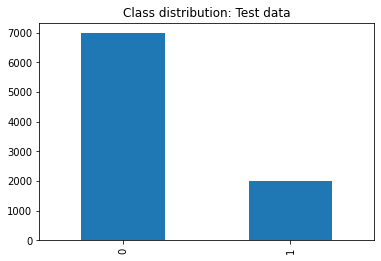

In [ ]:
# Test data
y_test.value_counts().plot(kind='bar', title='Class distribution: Test data')
y_test.value_counts() #22% defaulters in the test data

## No resampling - used the original imbalanced dataset

In [ ]:
# Scale input variables for training (x_train)
min_max_scaler = preprocessing.MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(x_train)

### Logistic regression

In [ ]:
LR = LogisticRegression(random_state=1, solver='liblinear') #solver:'lbfgs','newton-cg','liblinear', 'sag', 'saga', default penalty is 'l2'
# Fit the model
LR.fit(x_train_scaled, y_train)
# Predict using the scaled x_test
x_test_scaled = min_max_scaler.transform(x_test)
y_pred = LR.predict(x_test_scaled)

### Performance metrics

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy', accuracy_score(y_test, y_pred))
print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))

[[6784  197]
 [1527  482]]
accuracy 0.8082313681868744
precision 0.7098674521354934
recall 0.23992035838725734


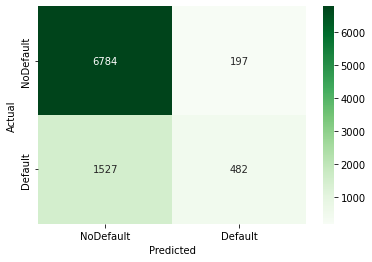

In [ ]:
# Graphic visualization of the confusion matrix
ax= plt.subplot()
sns.heatmap(cm,annot=True,fmt='g', ax=ax, cmap='Greens');  #annot=True to include the numeric values, ftm='g' to avoid scientific notation

ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.xaxis.set_ticklabels(['NoDefault', 'Default']); 
ax.yaxis.set_ticklabels(['NoDefault', 'Default']);

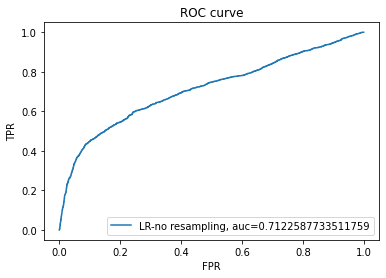

In [ ]:
# ROC curve, and ROC AUC
y_pred_proba = LR.predict_proba(x_test_scaled)[::,1]  #probability estimated from LR   #[start:stop:step]
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="LR-no resampling, auc="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)   #place the legend in the lower right corner
plt.show()

## Under-sampling the majority class + train a LR model


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


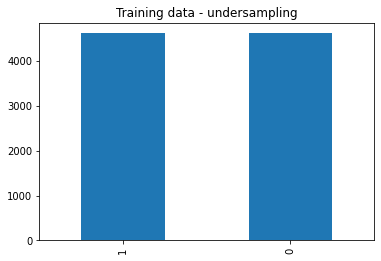

In [ ]:
rus = RandomUnderSampler(return_indices=True, random_state=1)
X_rus, y_rus, id_rus = rus.fit_resample(x_train_scaled, y_train.squeeze())
#Now to check the training data distribution after undersampling
pd.Series(y_rus.reshape(-1)).value_counts().plot(kind='bar', title='Training data - undersampling');   #convert numpy array to panda's series to use panda's value_counts()
#training data is now balanced

In [ ]:
#repeat fitting and predicting with logistic regression:
LR_us = LogisticRegression(random_state=1, solver='liblinear')
# Fit the model
LR_us.fit(X_rus, y_rus.squeeze())
# Predict using the scaled x_test
y_pred = LR_us.predict(x_test_scaled)

[[5047 1934]
 [ 764 1245]]
accuracy 0.699888765294772
precision 0.39163258886442276
recall 0.6197112991538078


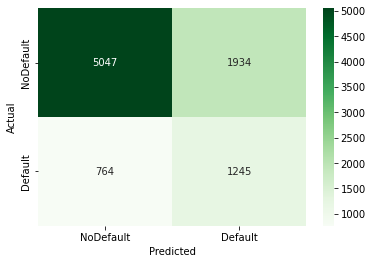

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy', accuracy_score(y_test, y_pred))
print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))
# Graphic visualization of the confusion matrix
ax= plt.subplot()
sns.heatmap(cm,annot=True,fmt='g', ax=ax, cmap='Greens');  #annot=True to include the numeric values, ftm='g' to avoid scientific notation

ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.xaxis.set_ticklabels(['NoDefault', 'Default']); 
ax.yaxis.set_ticklabels(['NoDefault', 'Default']);
# result: with undersampling the training data, accuracy and precision suffered, but recall improved

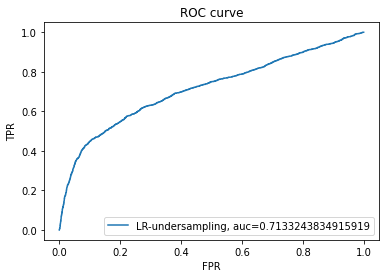

In [ ]:
# ROC curve, and ROC AUC
y_pred_proba = LR_us.predict_proba(x_test_scaled)[::,1]  #probability estimated from LR   #[start:stop:step]
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="LR-undersampling, auc="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)  
plt.show()

## Over-sampling the majority class + train a LR model


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


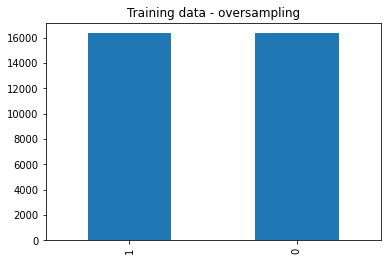

In [ ]:
ros = RandomOverSampler(return_indices=True, random_state=1)
X_ros, y_ros, id_ros = ros.fit_resample(x_train_scaled, y_train.squeeze())
#Now to check the training data distribution after oversampling
pd.Series(y_ros.reshape(-1)).value_counts().plot(kind='bar', title='Training data - oversampling');   #convert numpy array to panda's series to use panda's value_counts()
#training data is now balanced

In [ ]:
#repeat fitting and predicting with logistic regression:
LR_os = LogisticRegression(random_state=1, solver='liblinear')
# Fit the model
LR_os.fit(X_ros, y_ros)
# Predict using the scaled x_test
y_pred = LR_os.predict(x_test_scaled)

[[4969 2012]
 [ 748 1261]]
accuracy 0.692992213570634
precision 0.3852734494347693
recall 0.6276754604280737


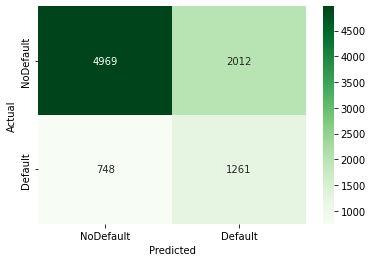

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy', accuracy_score(y_test, y_pred))
print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))
# Graphic visualization of the confusion matrix
ax= plt.subplot()
sns.heatmap(cm,annot=True,fmt='g', ax=ax, cmap='Greens');  #annot=True to include the numeric values, ftm='g' to avoid scientific notation

ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.xaxis.set_ticklabels(['NoDefault', 'Default']); 
ax.yaxis.set_ticklabels(['NoDefault', 'Default']);
# result: oversampling has similar performance to undersampling

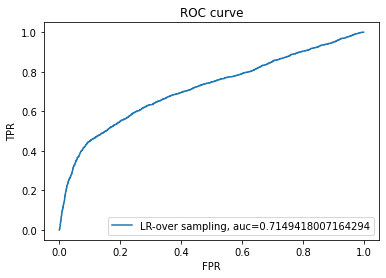

In [ ]:
# ROC curve, and ROC AUC
y_pred_proba = LR_os.predict_proba(x_test_scaled)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="LR-over sampling, auc="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)  
plt.show()

## Using both undersampling and oversampling + train a LR model

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


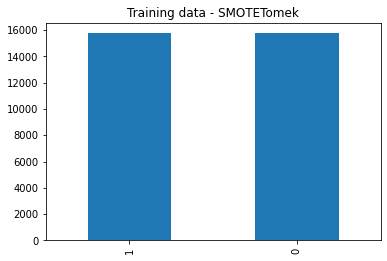

In [ ]:
x_smt, y_smt = SMOTETomek(random_state=1).fit_sample(x_train_scaled, y_train.squeeze())
#Now to check the training data distribution:
pd.Series(y_smt.reshape(-1)).value_counts().plot(kind='bar', title='Training data - SMOTETomek');   
#training data is now balanced

In [ ]:
#repeat fitting and predicting with logistic regression:
LR_smt = LogisticRegression(random_state=1, solver='liblinear', penalty='l1')   #default penality='l2'
# Fit the model
LR_smt.fit(x_smt, y_smt)
# Predict using the scaled x_test
y_pred = LR_smt.predict(x_test_scaled)

In [ ]:
#same performance between l1 and l2 penalty. But the l1 penalty reduced some of the coefficients to zero.
column_labels = df_independent.columns.tolist()
coef = LR_smt.coef_.squeeze().tolist()
# Zip together
labels_coef = list(zip(column_labels, coef))
print(labels_coef)
print(LR_smt.intercept_)
# coefficients for Repay_June, and Bill_May are reduced to zero.

[('LIMIT_BAL', -0.9911510708551642), ('SEX', -0.11380413540340302), ('EDUCATION', -0.28234179240855295), ('MARRIAGE', -0.3848891410296028), ('AGE', 0.31170516619952787), ('Repay_Sept', 5.367874181334451), ('Repay_Aug', 1.0787473816376605), ('Repay_July', 0.6136194082941878), ('Repay_June', 0.0), ('Repay_May', 0.04802380184376096), ('Repay_Apr', 0.04667828550850049), ('Bill_Sept', -4.6052808076736635), ('Bill_Aug', 0.8594555487875079), ('Bill_July', 1.1474550781100228), ('Bill_June', 1.3174096973112688), ('Bill_May', 0.0), ('Bill_Apr', 0.8364492020336722), ('Pay_Sept', -15.373818503130556), ('Pay_Aug', -10.944389684851998), ('Pay_July', -6.691640093699221), ('Pay_June', -3.208914878204537), ('Pay_May', -1.308362184597507), ('Pay_Apr', -1.6037870340479032)]


[[4822 2159]
 [ 719 1290]]
accuracy 0.6798665183537264
precision 0.3740214554943462
recall 0.6421105027376804


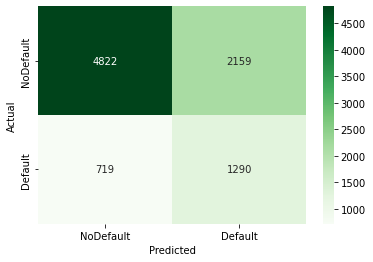

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy', accuracy_score(y_test, y_pred))
print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))
# Graphic visualization of the confusion matrix
ax= plt.subplot()
sns.heatmap(cm,annot=True,fmt='g', ax=ax, cmap='Greens');  

ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.xaxis.set_ticklabels(['NoDefault', 'Default']); 
ax.yaxis.set_ticklabels(['NoDefault', 'Default']);
# result: similar performance to under and over sampling

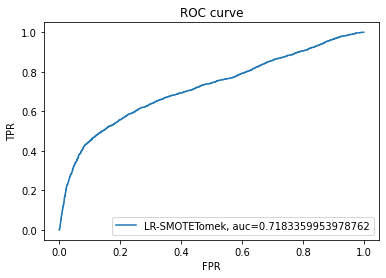

In [ ]:
# ROC curve, and ROC AUC
y_pred_proba = LR_smt.predict_proba(x_test_scaled)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="LR-SMOTETomek, auc="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)  
plt.show()